# Test of new velocity databse script

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate


%matplotlib inline
sns.set(color_codes=True)
pd.options.mode.chained_assignment = None 

# data loading
path = '../datasets/preprocessed/'
# dfrat     = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')

dfrat     = pd.read_hdf(path+'filteredDatabase.h5', 'Rat_Behavior').set_index('index')
dfratv    = pd.read_hdf(path+'velocityDatabase.h5', 'Rat_Behavior').set_index('index')

dfevent   = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
dfsession = pd.read_hdf(path+'relationalDatabase.h5', 'Sessions')

In [2]:
## VECTORS WITHOUT Y
dfOri = pd.DataFrame()

for name, dd in dfrat.groupby('session_id'):
    dd['dT'] = dd['Time'].diff(1)
    
    # calculating lenghts of VecX and VecZ and creation of shifted vectors  #dd = dd.apply(decompose_vec_df, axis=1)
    dd['lVo'] = np.linalg.norm(np.array([dd.X_Ori, dd.Y_Ori, dd.Z_Ori])  )
    dd['lx1'] = dd['X_Ori'] / dd['lVo']
    dd['lz1'] = dd['Z_Ori'] / dd['lVo']
    
    # normalize the data to unit vector form
    dd['V1'] = np.linalg.norm(np.array([dd.lx1, 0, dd.lz1]))
    dd['lx1'] = dd.lx1 / dd.V1
    dd['lz1'] = dd.lz1 / dd.V1

    dfOri = pd.concat([dfOri, dd], axis=0, ignore_index=True)

dfOri = dfOri.replace([np.inf, -np.inf], np.nan).dropna()# print(dfOri)

In [29]:
## ANGLES and VELOCITY
dfOri2 = pd.DataFrame()

# calculatinig the angles between X axis and the vectors
for name, dd in dfOri.groupby('session_id'):
    dd['lx2'] = dd.lx1.shift(1)
    dd['lz2'] = dd.lz1.shift(1)
    
    V1 = np.array([dd.lx1, 0, dd.lz1])
    V2 = np.array([1     , 0, 0     ])
    V3 = np.array([dd.lx2, 0, dd.lz2])
    
    dd['clockwise'] = dd.lz1 * dd.lx2 > dd.lx1 * dd.lz2

    dd.clockwise = dd.clockwise.astype(int)
    dd.clockwise = dd.clockwise.replace(to_replace=0, value=-1)
    dd.clockwise
    dd['theta'] = np.arccos(np.dot(V1, V3) / (np.linalg.norm(V1) * np.linalg.norm(V3)))
    
    # angular velocity between two vectors
    dd['U'] = np.degrees(dd.theta * dd.clockwise)/ dd.dT       
    dfOri2 = pd.concat([dfOri2, dd], axis=0, ignore_index=True)    

dfOri2 = dfOri2.replace([np.inf, -np.inf], np.nan).dropna()

/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in arccos


In [30]:
## ANGLES and VELOCITY
dfOri2 = pd.DataFrame()

# calculatinig the angles between X axis and the vectors
for name, dd in dfOri.groupby('session_id'):
    dd['lx2'] = dd.lx1.shift(1)
    dd['lz2'] = dd.lz1.shift(1)
    
    V1 = np.array([dd.lx1, 0, dd.lz1])
    V2 = np.array([1     , 0, 0     ])
    V3 = np.array([dd.lx2, 0, dd.lz2])
    
    dd['clockwise'] = dd.lz1 * dd.lx2 > dd.lx1 * dd.lz2

    dd.clockwise = dd.clockwise.astype(int)
    dd.clockwise = dd.clockwise.replace(to_replace=0, value=-1)
    dd.clockwise
    
#   theta0 = np.arccos(lx1*1 + lz1*0 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
    dd['theta0'] = np.arccos(dd.lx1 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
    dd['theta1'] = dd.theta0.shift(1)    
    dd['thetaB']  = dd.theta0 - dd.theta1    
    dd.drop({'theta0','theta1'}, axis=1, inplace=True)

    # angular velocity between two vectors
    dd['UB'] = np.degrees(np.absolute(dd.thetaB) * dd.clockwise)/ dd.dT       
    dfOri2 = pd.concat([dfOri2, dd], axis=0, ignore_index=True)    

dfOri2 = dfOri2.replace([np.inf, -np.inf], np.nan).dropna()

In [4]:
dfOriU = pd.DataFrame()
dfOri2 = dfOri2[np.absolute(dfOri2['dT']) < 0.005] # filtering out big time gaps frame points

for name, dd in dfOri2.groupby('session_id'):
    dd['UM'] = dd['U'].rolling(window=20).mean()
    dd['UBM'] = dd['UB'].rolling(window=20).mean()
    dfOriU = pd.concat([dfOriU, dd], axis=0, ignore_index=True)    

In [5]:
dfOriU['test'] = dfOriU.theta - dfOriU.thetaB
dfOriU['Utest'] = dfOriU.U - dfOriU.UB

In [6]:
dfOriU.max()

Frame         245041.000000
Time            1021.004232
X_Pos              0.119883
Y_Pos              0.129625
Z_Pos              0.080412
X_Ori              0.999885
Y_Ori              0.543822
Z_Ori              0.999821
session_id         7.000000
dT                 0.004167
lVo              399.932827
lx1                1.000000
lz1                1.000000
V1                 0.004233
lx2                1.000000
lz2                1.000000
clockwise          1.000000
theta              1.424927
thetaB             1.312583
UB             12026.328403
U              12026.328403
UM              2030.888353
UBM             1765.120118
test               1.473796
Utest           5435.750842
dtype: float64

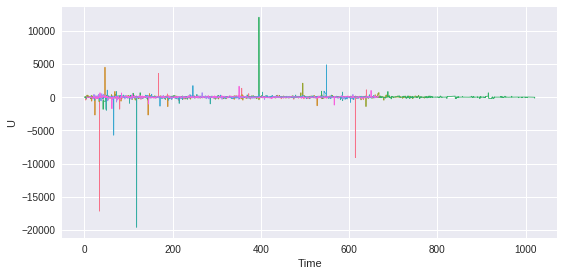

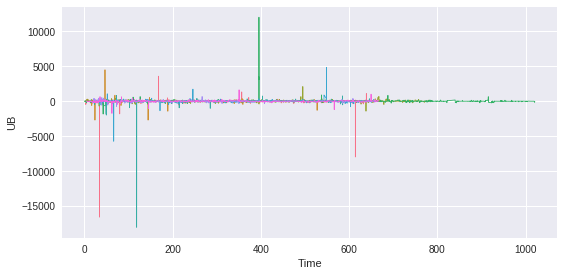

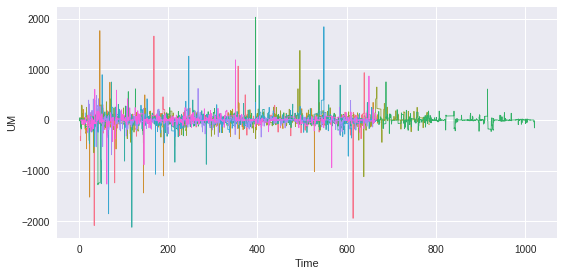

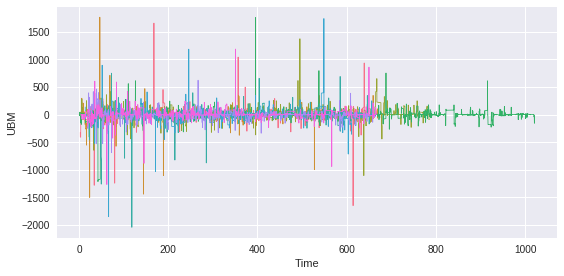

In [7]:
g = sns.FacetGrid(hue='session_id', data=dfOriU, size=4, aspect=2)#, hue_order=[0,1])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOriU, size=4, aspect=2)#, hue_order=[0,1])
g.map(plt.plot, "Time", "UB", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOriU, size=4, aspect=2)#, hue_order=[0,1])
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOriU, size=4, aspect=2)#, hue_order=[0,1])
g.map(plt.plot, "Time", "UBM", alpha=1, linewidth=0.8);


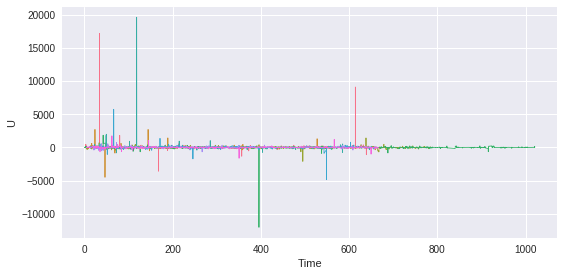

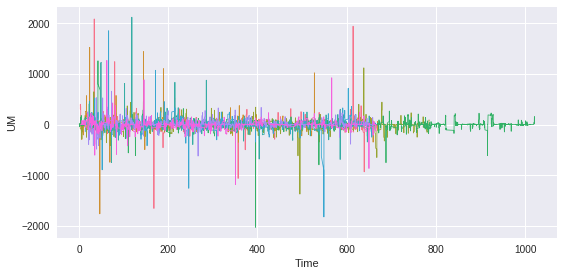

In [8]:
g = sns.FacetGrid(hue='session_id', data=dfratv, size=4, aspect=2)#, hue_order=[0,1])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfratv, size=4, aspect=2)#, hue_order=[0,1])
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=0.8);

In [16]:
print(len(dfratv))
print(len(dfratv[dfratv['UM']<2000]))
print(len(dfratv[dfratv['UM']<1500]))

761820
761289
761244


In [17]:
dfratvfil = dfratv[dfratv['UM']<1500]

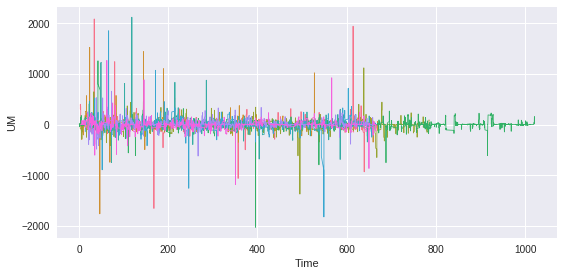

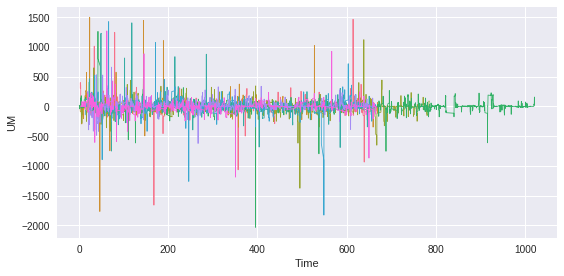

In [19]:
g = sns.FacetGrid(hue='session_id', data=dfratv, size=4, aspect=2)#, hue_order=[0,1])
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfratvfil, size=4, aspect=2)#, hue_order=[0,1])
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=0.8);

## Experiment 2

In [21]:
dd2 = dfratv[dfratv['session_id']==2]

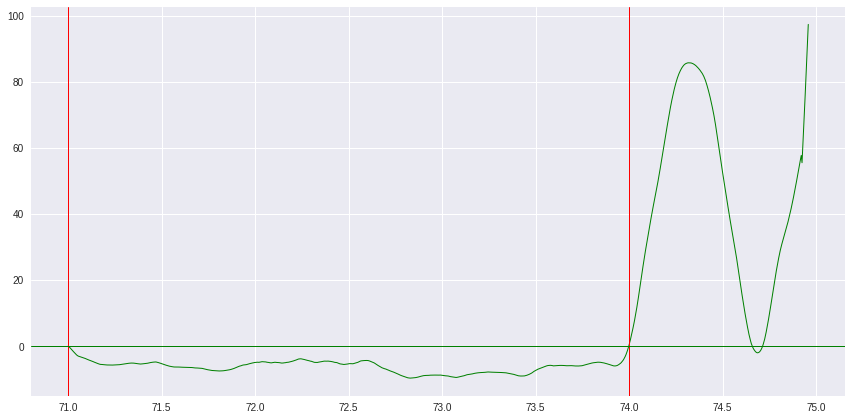

In [23]:
#  71, 73
dpart = dd2[(dd2['Time']>71) & (dd2['Time']<75)]
xmin, xmax = 71, 74

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
# g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');
# g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
# g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');

## Experiment 4

In [24]:
dd4 = dfratv[dfratv['session_id']==4]

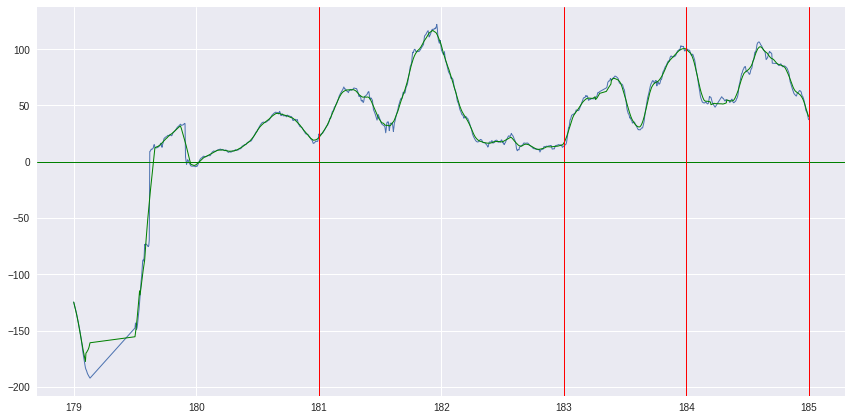

In [28]:
# 181, 183, 184, 185
dpart = dd4[(dd4['Time']>179) & (dd4['Time']<185)]
xmin, xmax =  181, 183

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');
# g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
# g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');

xmin, xmax =  184, 185
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');